# Data Reading and Transformations
For predictiing Taipei Real Estate price

In [9]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression, LassoCV, Ridge, RidgeCV,Lasso
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import svm
from sklearn.model_selection import KFold,LeaveOneOut, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.metrics import mean_squared_error

In [10]:
# Read the data set and get a breif look at the values 
data = pd.read_csv("taipei_train.csv")
dataTest = pd.read_csv("taipei_test.csv")
data.head()
data.describe()

,total_ntd,land_area,building_area,num_room,num_hall,num_toilet,transaction_year,transaction_month,building_age
count,1.587000e+03,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000
mean,1.595045e+07,26.402817,93.484726,2.666037,1.663516,1.595463,2018.994959,10.686200,1945.056588
std,1.065980e+07,29.642330,42.998593,1.094236,0.592256,0.790983,0.117669,1.194177,15.777181
min,1.382000e+04,0.030000,0.130000,1.000000,0.000000,0.000000,2015.000000,2.000000,1908.000000
25%,9.750000e+06,14.565000,64.610000,2.000000,1.000000,1.000000,2019.000000,10.000000,1939.816666
50%,1.400000e+07,24.750000,91.320000,3.000000,2.000000,1.000000,2019.000000,11.000000,1947.000000
75%,1.941500e+07,32.610000,115.305000,3.000000,2.000000,2.000000,2019.000000,12.000000,1954.000000
max,2.300000e+08,717.540000,526.690000,10.000000,5.000000,10.000000,2019.000000,12.000000,2019.000000


In [11]:
df1 = data.loc[(data['district'] == 'Nangang District') | 
               (data['district'] == 'Datong District') |
               (data['district'] == 'Zhongzheng District') |
               (data['main_building_material'] == 'Wooden') |
               (data['main_building_material'] == 'See license') |
               (data['main_building_material'] == 'See other registration items') |
               (data['main_building_material'] == 'Stone building') |
               (data['main_building_material'] == 'Wall type reinforced concrete construction') |
               (data['main_building_material'] == 'Steel reinforced concrete construction') |
               (data['main_building_material'] == 'Brickwork')]
df2 = data.drop(df1.index,inplace = True)
#data.replace('Wall type reinforced concrete construction','Reinforced concrete construction')
data.describe()

,total_ntd,land_area,building_area,num_room,num_hall,num_toilet,transaction_year,transaction_month,building_age
count,1.370000e+03,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000,1370.000000
mean,1.594929e+07,26.747219,94.678321,2.694891,1.681022,1.607299,2018.994161,10.716788,1945.572533
std,9.113487e+06,25.221050,41.592253,1.094666,0.584438,0.798431,0.126633,1.160626,14.203152
min,1.382000e+04,0.030000,0.130000,1.000000,0.000000,0.000000,2015.000000,2.000000,1908.000000
25%,1.000000e+07,15.137500,68.052500,2.000000,1.000000,1.000000,2019.000000,10.000000,1941.000000
50%,1.421500e+07,25.295000,92.515000,3.000000,2.000000,2.000000,2019.000000,11.000000,1947.000000
75%,1.950000e+07,33.467500,116.060000,3.000000,2.000000,2.000000,2019.000000,12.000000,1953.000000
max,7.980000e+07,527.000000,476.970000,10.000000,5.000000,10.000000,2019.000000,12.000000,2019.000000


In [12]:
# Helper Functions

def dataClean(data): # All the data transformations
    ind = pd.get_dummies(data, columns = ['district','main_building_material']).drop(['total_ntd'],axis = 1) # Encode the categorical features
    ind[['building_age']] = 2022-ind[['building_age']] # Gives the building age rather than birth data
    
    # Interaction Terms
    #ind[['space']] = ind[['building_area']]#.add(ind[['num_room']],axis = 'columns')#+(ind[['num_toilet']]))
    #ind[['space']] = np.divide(ind[['space']],np.add(ind[['num_room']],ind[['num_toilet']]))
    ind[['bul_room']] =np.multiply(ind[['num_room']],np.asarray(ind[['building_area']]))
    ind[['bul_halls']]=np.multiply(ind[['num_hall']],np.asarray(ind[['building_area']]))
    ind[['bul_hall2']]=np.multiply(ind[['num_hall']]**2,np.asarray(ind[['building_area']]))
    
    # Transformations on select features
    ind[['land_area']] = np.sqrt(ind[['land_area']]) 
    ind[['building_area']] = np.sqrt(ind[['building_area']])
    ind[['transaction_month']] = np.log(ind[['transaction_month']])
    ind[['num_hall']] = ind[['num_hall']]**2
    
    # Handling Categorical Features to Ordinal
    enc = preprocessing.OrdinalEncoder()
    #data['region'] = enc.fit_transform(data['region'].values.reshape(nrows,1))
    ind[['district_ordinal']] = enc.fit_transform(data[['district']])
    

    return ind 

def plotError(model,x,y): # Plots the residual error
    pred = model.predict(x)
    plt.scatter(range(y.size),abs(y-pred)**2)
    return mean_squared_error(y, pred, squared=True)

def getRMSE(model,x,y,squared = False): # Gets the RMSE or MSE (False for RMSE)
    return mean_squared_error(np.square(y),np.square(model.predict(x)),squared=squared)
    #return mean_squared_error((y),(model.predict(x)),squared=squared)
    
def printAttributes(model,X_test,y_test): # Print the attributs of NN model
    print("features:",model.n_features_in_)
    print("num layers:",model.n_layers_)
    print("num iterations:",model.n_iter_)
    print("num outputs:",model.n_outputs_)
    print("num features in:",model.n_features_in_)
    print("t:",model.t_)
    print("current loss:",model.loss_)
    print("output activation func:",model.out_activation_)
    print("R2:",model.score(X_test,y_test))
    print("RMSE:",(getRMSE(model,X_test,y_test,False)))
    print("MSE:",(getRMSE(model,X_test,y_test,True)))

In [13]:
# Perform the transformations and wrangling, then inspect the first few elements
ind = dataClean(data)
ind.head()
#dataClean(dataTest).head()

,land_area,building_area,num_room,num_hall,num_toilet,transaction_year,transaction_month,building_age,district_Beitou,district_Daan District,...,district_Wenshan District,district_Xinyi District,district_Zhongshan Area,district_shihlin,main_building_material_Reinforced concrete construction,main_building_material_Strengthen brickwork,bul_room,bul_halls,bul_hall2,district_ordinal
0,22.956481,21.839643,10,9,4,2019,2.197225,78.0,0,0,...,0,1,0,0,1,0,4769.70,1430.91,4292.73,6.0
1,6.838860,11.339312,10,0,10,2019,2.302585,75.0,0,0,...,1,0,0,0,1,0,1285.80,0.00,0.00,5.0
2,6.151423,12.192211,9,0,9,2019,2.397895,73.0,0,0,...,0,0,0,0,1,0,1337.85,0.00,0.00,2.0
3,4.732864,8.715503,7,0,7,2019,2.197225,71.0,0,0,...,0,0,1,0,1,0,531.72,0.00,0.00,7.0
4,4.898979,8.587782,7,4,3,2019,2.397895,71.0,0,0,...,0,0,1,0,1,0,516.25,147.50,295.00,7.0


In [14]:
# Take a transformation of the dependent feature
dep = np.sqrt(data[['total_ntd']]) # Square Root transformation
#dep = np.log(data[['total_ntd']]) # Log Transformation

dataMod = pd.concat([ind,dep],axis=1) # Merge the independent and dependent in one data frame
dataMod.head()
dataMod.sum(axis = 0)

land_area                                                  6.685951e+03
building_area                                              1.301417e+04
num_room                                                   3.692000e+03
num_hall                                                   4.339000e+03
num_toilet                                                 2.202000e+03
transaction_year                                           2.766022e+06
transaction_month                                          3.239126e+03
building_age                                               1.047056e+05
district_Beitou                                            1.450000e+02
district_Daan District                                     1.490000e+02
district_Neihu District                                    1.900000e+02
district_Songshan District                                 1.530000e+02
district_Wanhua District                                   1.030000e+02
district_Wenshan District                                  1.270

# Data visualization and Analysis

<AxesSubplot:>

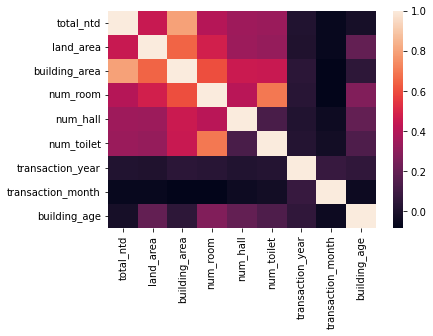

In [15]:
# Plot a correlation Heatmap
data.corr()
sns.heatmap(data.corr())

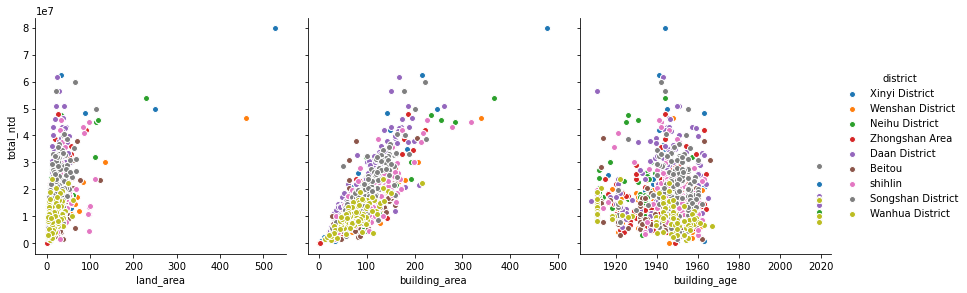

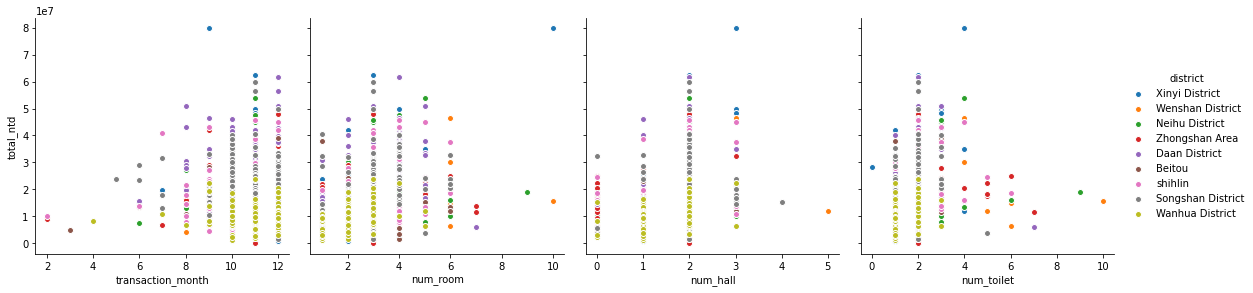

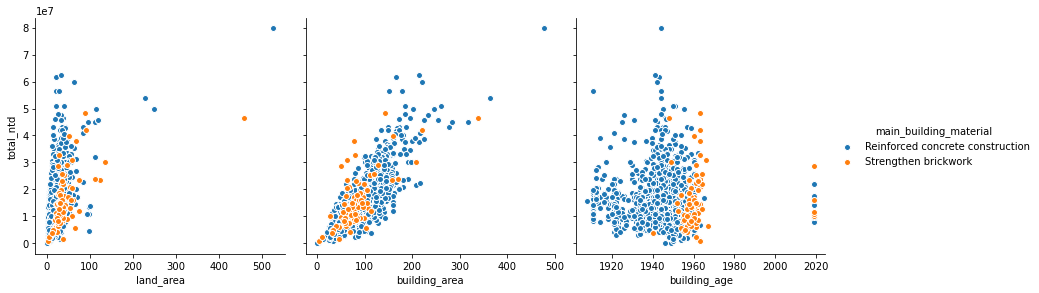

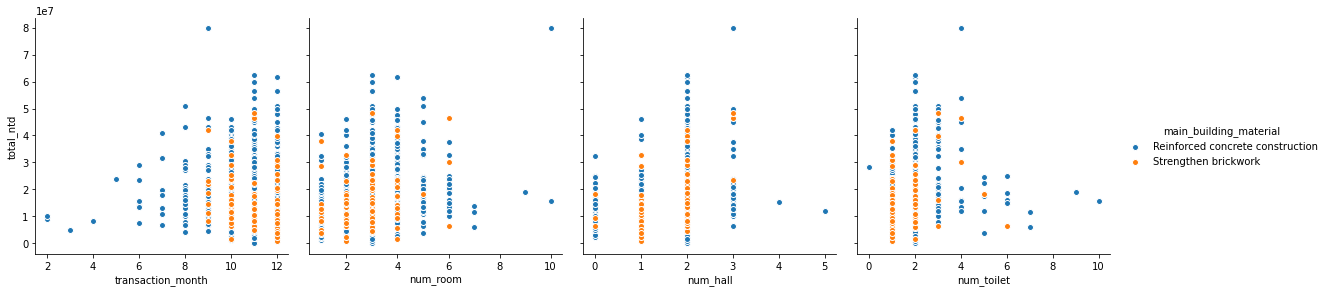

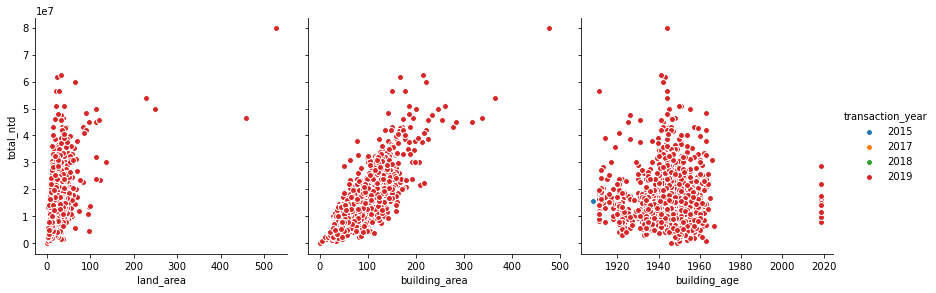

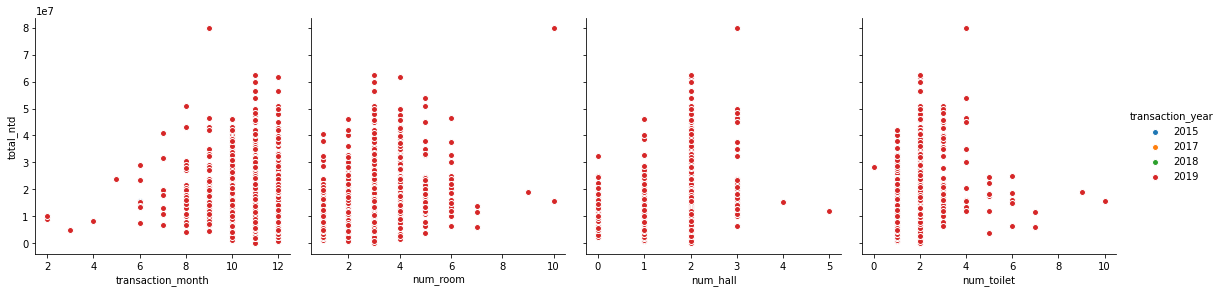

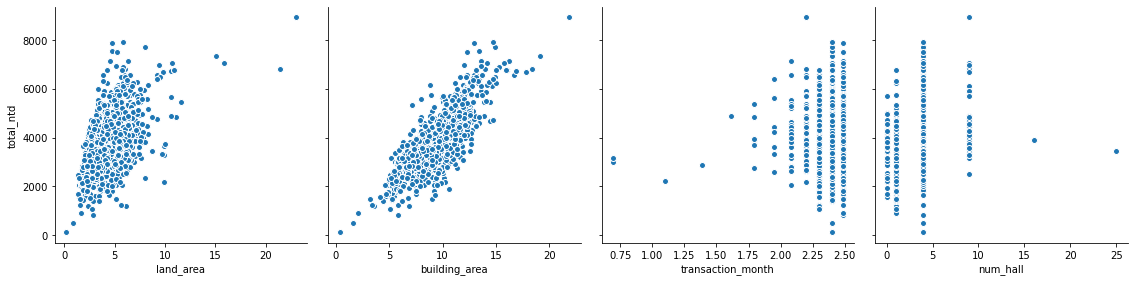

In [16]:
# Plots of the data values before and after some transformations
hue = "district"
hue2 = "main_building_material"
hue3 = "transaction_year"

g = sns.PairGrid(data, y_vars = ['total_ntd'], x_vars = ['land_area','building_area','building_age'], hue = hue,height=4)
g.map(plt.scatter,edgecolor="white")
#g.title("Graphs")
#g.map(sns.kdeplot,legend=False)
g.add_legend()
g1 = sns.PairGrid(data, y_vars = ['total_ntd'], x_vars = ['transaction_month','num_room','num_hall','num_toilet'],hue = hue, height = 4)
g1.map(plt.scatter, edgecolor = "white")
g1.add_legend()

g4 = sns.PairGrid(data, y_vars = ['total_ntd'], x_vars = ['land_area','building_area','building_age'], hue = hue2,height=4)
g4.map(plt.scatter,edgecolor="white")
#g.map(sns.kdeplot,legend=False)
g4.add_legend()
g5 = sns.PairGrid(data, y_vars = ['total_ntd'], x_vars = ['transaction_month','num_room','num_hall','num_toilet'],hue = hue2, height = 4)
g5.map(plt.scatter, edgecolor = "white")
g5.add_legend()

g6 = sns.PairGrid(data, y_vars = ['total_ntd'], x_vars = ['land_area','building_area','building_age'], hue = hue3,height=4)
g6.map(plt.scatter,edgecolor="white")
#g.map(sns.kdeplot,legend=False)
g6.add_legend()
g7 = sns.PairGrid(data, y_vars = ['total_ntd'], x_vars = ['transaction_month','num_room','num_hall','num_toilet'],hue = hue3, height = 4)
g7.map(plt.scatter, edgecolor = "white")
g7.add_legend()

# If you want o plot the transformed data then put in dataMod instead of data for the first parameter 
g3 = sns.PairGrid(dataMod, y_vars = ['total_ntd'], x_vars = ['land_area','building_area','transaction_month','num_hall'], height=4)
g3.map(plt.scatter,edgecolor="white")

# Model Building, Training, and Testing

In [17]:
# Split the data into an artifical test set and training set from the origianl training set
X_train, X_test,y_train,y_test = train_test_split(ind,dep,test_size=0.2,random_state=17)

In [18]:
ml = LinearRegression()
clf_ml = ml.fit(X_train,y_train)
clf_ml.score(X_test,y_test)
mean_squared_error(y_test, clf_ml.predict(X_test), squared=True)
getRMSE(ml,X_test,y_test,False)
#mean_squared_error(y_test, np.square(clf_ml.predict(X_test)), squared=True)

4159456.1175611885

In [19]:
# from sklearn.model_selection import KFold
# def crossVal(x,y):
#     kf = KFold(n_splits=3)
#     #model.fit(x,y)
#     for train_index, test_index in kf.split(x):
#         print("Train:",train_index, "Test:",test_index)
#         X_train, X_test = x[train_index], x[test_index]
#         y_train, y_test = y[train_index], y[test_index]
    
# crossVal(ind,dep)

In [20]:
ml2 = LinearRegression()
scores = cross_val_score(ml2, X_train, y_train, cv = 4)
print(statistics.mean(scores))

0.7432318321352485


In [21]:
lass = LassoCV(random_state = 1,cv = 4, max_iter = 99999)
clf_lass = lass.fit(X_train, y_train.values.ravel())
clf_lass.score(X_test,y_test.values.ravel())


0.5835926210036997

In [22]:
lass = Lasso(max_iter = 999999)
clf_lass = lass.fit(X_train, y_train)
clf_lass.score(X_test,y_test)

0.7809600073017089

In [23]:
fold = 25
rid = Ridge(max_iter = 1000000)
clf_rid = rid.fit(X_train, y_train)
print(clf_rid.score(X_test,y_test))
print(statistics.mean(cross_val_score(clf_rid, X_test, y_test, cv=fold)))
#print(statistics.mean(cross_val_score(rid, X_train, y_train, cv=fold)))
y_ridgeCV_pred = cross_val_predict(rid, X_train, y_train, cv=fold)
y_ridgeCV_pred
#plt.plot(abs(y_ridgeCV_pred-dep)*abs(y_ridgeCV_pred-dep))

0.7804316764387809
0.6851624827636288


array([[3126.54941193],
       [2706.85949207],
       [4328.07224499],
       ...,
       [3408.92513788],
       [2381.98762137],
       [2274.4041473 ]])

In [24]:
ridCV = RidgeCV(cv = 5)
clf_ridCV = ridCV.fit(X_train, y_train)
clf_ridCV.score(X_test, y_test)

0.784085479481991

0.5535114199082736
0.44370210534771576


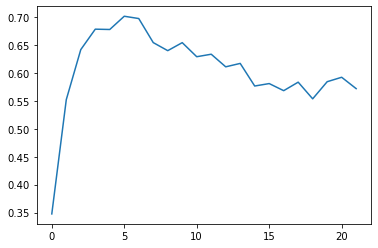

In [25]:
iter = 22
d = np.zeros(iter)
for i in range(iter):
    dec = DecisionTreeRegressor(max_depth = i+1)
    clf_dec = dec.fit(X_train, y_train)
    d[i] = clf_dec.score(X_test, y_test)
#print(d.index(min(d)))
DTReg = DecisionTreeRegressor(max_depth = 21)
print(DTReg.fit(X_train,y_train).score(X_test,y_test))
plt.plot(d)
print(statistics.mean(cross_val_score(clf_dec, X_test, y_test, cv=10)))

In [26]:
#min =DecisionTreeRegressor(max_depth=1).fit(X_train,y_train).score(X_train, y_train)
epsilon = .000001
temp = 0
iter = 100
r = np.zeros(iter)
min = 99999999
for i in range(iter):
    reg = DecisionTreeRegressor(max_depth=i+1,
                               min_samples_split = 3,
                               max_features = "auto",
                               random_state = 0)#.fit(ind,dep)
    #r[i] = getRMSE(reg,X_test, y_test,False)
    r[i]= mean_squared_error(np.square(dep),
                   np.square(cross_val_predict(reg,ind,np.asarray(dep).ravel(),cv=2)),
                   squared=False)
    if(min>r[i]):
        min =r[i]
        temp =i
        print(min)
        print(temp)
    #print(min)
print(min)
print(temp)
reg = DecisionTreeRegressor(max_depth=5,min_samples_split = 3,max_features = "auto",random_state = 0).fit(ind,dep)
reg.feature_importances_

7960459.148853166
0
6717069.917714493
1
6632140.7787172245
2
6567052.706781289
3
6567052.706781289
3


array([0.02906904, 0.88568649, 0.        , 0.        , 0.0058325 ,
       0.        , 0.        , 0.01201058, 0.        , 0.04407727,
       0.        , 0.01058287, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00186575,
       0.        , 0.00462878, 0.00624671])

0.7090341915483688
34


array([0.73944831, 0.74421799, 0.74323183, 0.74596329, 0.74071511,
       0.74129191, 0.74401275, 0.74114921, 0.74416741, 0.74442559,
       0.73574299, 0.73619268, 0.73527844, 0.73023481, 0.73512265,
       0.73083964, 0.72848752, 0.72606255, 0.72469921, 0.72801789,
       0.72963331, 0.72852652, 0.7221651 , 0.72944186, 0.72370836,
       0.72360566, 0.72452679, 0.72033729, 0.72047587, 0.72319997,
       0.72209363, 0.71083609, 0.71706257, 0.71725519, 0.70903419])

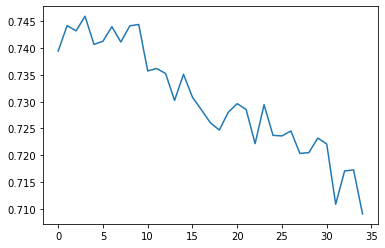

In [27]:
minTemp = 0.50
it = 35
temp = 0
epsilon = .000001
cv_scores = np.zeros(it)
for i in range(it):
    cv_scores[i] = statistics.mean(cross_val_score(ml2,X_train,y_train, cv = i+2))
    if(epsilon < abs(cv_scores[i]-min)):
        minTemp = cv_scores[i]
        temp = i
print(minTemp)
print(temp)
plt.plot(cv_scores)
cv_scores


In [28]:
poly = PolynomialFeatures(2)
polyData = poly.fit_transform(X_train)
polyTest = poly.fit_transform(X_test)
#clf_ml = ml.fit(polyData,y_train)
#print(clf_ml.score(polyTest,y_test))
#cross_val_score(clf_ml,X_test, y_test)

In [29]:
def optimalCVLayer(size,start,x,y):
    min = 9999999
    temp = 10**5
    for i in range(size):
        NNreg = MLPRegressor(hidden_layer_sizes = (i+start),
                             solver = "lbfgs",
                             random_state = 1,
                             max_iter = 10**10,
                             max_fun = 10**10
                            )
        #clf_NN = NNreg.fit(x,np.asarray(y_train).ravel())
        #temp = getRMSE(clf_NN,X_test,y_test,False)
        temp = mean_squared_error(np.square(dep),
                   np.square(cross_val_predict(NNreg,x,np.asarray(y).ravel(),cv=5)),
                   squared=False)
        if(temp < min):
            index = i+start
            min = temp
            print(temp)
            print(index)
    return index 

def optimalSingleLayer(size,X_train,y_train,X_test,y_test):
    min = 5172067
    temp = 10*1000
    for i in range(size):
        NNreg = MLPRegressor(hidden_layer_sizes = (i+1),
                             solver = "lbfgs",
                             random_state = 1,
                             max_iter = 10**10,
                             max_fun = 10**10
                            )
        clf_NN = NNreg.fit(X_train,np.asarray(y_train).ravel())
        temp = getRMSE(clf_NN,X_test,y_test,False)
        if(temp < min):
            index = i+1
            min = temp
            print(temp)
            print(index)
    return index
def optimalDoubleLayer(layer_sz,first_layer_start,second_layer_start,x,y):
    min = 9999999999
    temp = 10*1000
    ibuff = first_layer_start
    jbuff = second_layer_start
    kbuff = 1
    for i in range(layer_sz):
        for j in range(layer_sz):
            #for k in range(layer_sz):
            NNreg = MLPRegressor(#hidden_layer_sizes=(i+1,j+1,k+1),
                                hidden_layer_sizes=(i+ibuff,j+jbuff),
                                #activation = 'relu',
                                solver = "lbfgs", # Quasi Newton Method of convergence
                                #learning_rate = 'adaptive',
                                #learning_rate = 'invscaling',
                                random_state=1, 
                                max_iter=10**10, 
                                max_fun = 10**10, 
                                warm_start = True
                                )
            #clf_NN = NNreg.fit(X_train,np.asarray(y_train).ravel())
            temp = mean_squared_error(np.square(dep),
                   np.square(cross_val_predict(NNreg,x,np.asarray(y).ravel(),cv=6)),
                   squared=False)
                
            if(temp < min):
                index = [i+ibuff,j+jbuff]
                min = temp
                print(temp)
                print(index)
    return index

def optimalTripleLayer(size,layer_start,X_train,y_train,X_test,y_test):
    min = 99999999
    temp = 10*10000
    for i in range(size):
        for j in range(size):
            for k in range(size):
                NNreg = MLPRegressor(hidden_layer_sizes = (i+layer_start,j+layer_start,k+layer_start),
                                     solver = "lbfgs",
                                     random_state = 1,
                                     max_iter = 3000,
                                     max_fun = 3000,
                                     tol = 0.1
                                    )
                clf_NN = NNreg.fit(X_train,np.asarray(y_train).ravel())
                temp = getRMSE(clf_NN, X_test, y_test,False)
                if(temp < min):
                    index = [i+layer_start,j+layer_start,k+layer_start]
                    min = temp 
                    print(temp)
                    print(index)
    return index
def optimalSevenLayer(size,X_train,y_train,X_test,y_test):
    min = 99999999
    temp = 10*10000
    for i in range(size):
        for j in range(size):
            for k in range(size):
                for z in range(size):
                    for x in range(size):
                        for y in range(size):
                            for n in range(size):
                                NNreg = MLPRegressor(hidden_layer_sizes = (i+1,j+1,k+1,z+1,x+1,y+1,n+1),
                                                     #solver = "lbfgs",
                                                     random_state = 1,
                                                     max_iter = 10**100,
                                                     max_fun = 10**100,
                                                     warm_start = True
                                                    )
                                clf_NN = NNreg.fit(X_train,np.asarray(y_train).ravel())
                                temp = getRMSE(clf_NN, X_test, y_test,False)
                                if(temp < min):
                                    index = [i+1,j+1,k+1,z+1,x+1,y+1,n+1]
                                    min = temp 
                                    print(temp)
                                    print(index)
    return index

In [30]:
#optimalSingleLayer(100,X_train,y_train,X_test,y_test)
# optimalDoubleLayer(100,
#              first_layer_start = 1,
#              second_layer_start = 1, 
#              x = ind,
#              y = dep)
#optimalTripleLayer(1,2,X_train,y_train,X_test,y_test)
#optimalSevenLayer(5,X_train,y_train,X_test,y_test)
#optimalCVLayer(10,1,ind,dep)
# 100,5 gives 4.27 million rmse 
# 32,7 gives 4,178,075.22 RMSE checked from (25:35,4:14)
# 19,13 gives 4,260,434.92470026 RMSE check from (15:25,4,14)
# 19,13 gives 4,260,434.92470026 RMSE check from (15:25,10:20)
# 19,13 gives 4,260,434.92470026 RMSE check from (25:35,20:30)
# 31,36 gives RMSE check from (30:40,30:40)

# Optimizing Layer Sizes of Neural Network Regression
| interval swept | optimal sizes | RMSE|
|--- | --- | --- |
| (10:20,10:20) | (19,13) | 4260434.92470026 |
| (20:30,10:20) | (27,10) | 4222355.246972126 |
| (30:40,30:40) | (31,36) | 4172617.4129091934 |
| (30:40,10:20) | (38,13) | 4217765.658428511 |
| (40:50,10:20) | (44,15) | 4169263.694989402 |
| (50:60,10:20) | (59,10) | 4199778.72754453 |
| (40:50,20:30) | (48,21) | 4345828.196307346 |
| (30:40,20:30) | (39,23) | 4138082.0072523 |
| (20:30,20:30) | (22,21) | 4104801.5259417016 |
| (10:20,20:30) | (10,25) | 4222420.512207868 |
| (20:30,30:40) | (29,33) | 4138742.0516132214 |
| (40:50,40:50) | (45,40) | 4271279.337414408 |
| (60:70,10:20) | (60,13) | 4138871.9285729392 | 
| (70:80,10:20) | (78,16) | 4255512.442859989 |
| (1:7,1:7,1:7) | (7,3,7) | 4303128.439201677 |
| (1:100) | (29) | 4255615.107205636 |
| (1:5) for 6 layers | (5,4,2,3,1,4) |  4113797.00804954 |
| (1:150,1:150,1:150) | (2,124,50) | 4026324.816539755 |

In [31]:
# Neural Network Regression Model after selecting the proper layers
NNreg = MLPRegressor(hidden_layer_sizes=(2,124,50),
                     #activation = 'relu',
                     solver = "lbfgs", # Quasi Newton Method of convergence
                     #learning_rate = 'adaptive',
                     #learning_rate = 'invscaling',
                     random_state=1, 
                     max_iter=10**10, 
                     max_fun = 10**10, 
                     warm_start = True
                    )                    
clf_NN = NNreg.fit(X_train, np.asarray(y_train).ravel())
clf_NN.score(X_test, y_test)
print(clf_NN.n_features_in_)
print(clf_NN.n_layers_)
print(clf_NN.n_iter_)
print(getRMSE(clf_NN,X_test,y_test,False))

23
5
424
7024870.120511949


In [32]:
# Neural Network Regression Model after selecting the proper layers
NNreg_CV = MLPRegressor(hidden_layer_sizes=(6,6),
                     #activation = 'relu',
                     solver = "lbfgs", # Quasi Newton Method of convergence
                     #learning_rate = 'adaptive',
                     #learning_rate = 'invscaling',
                     random_state=1, 
                     max_iter=10**10, 
                     max_fun = 10**10, 
                     warm_start = True
                    )                    
clf_NN2 = NNreg_CV.fit(ind, np.asarray(dep).ravel())
print(mean_squared_error(np.square(dep),
                   np.square(cross_val_predict(NNreg_CV,ind,np.asarray(dep).ravel(),cv=6)),
                   squared=False))
#clf_NN.score(X_test, y_test)

#print(getRMSE(clf_NN_CV,X_test,y_test,False))
#clf_NN_whole = NNreg.fit(dep, np.asarray(ind).ravel())
# mean_squared_error(np.square(dep),
#                    np.square(cross_val_predict(NNreg_CV,ind,np.asarray(dep).ravel(),cv=2)),
#                    squared=False)
#clf_NN_whole.predict(
# scores = cross_validate(NNreg_CV,ind,np.asarray(dep).ravel(), cv = 3,
#                         #scoring = ('r2','mean_squared_error'),
#                         return_train_score = True)
# scores

4873976.845803763


[0.65147959 0.68382435 0.63497717 0.61039381 0.66735097 0.68726101]


89621158.07859991

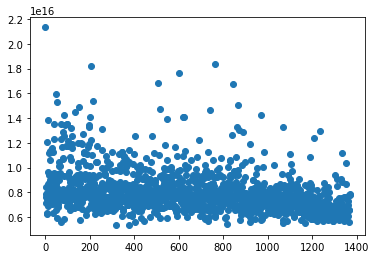

In [33]:
print(cross_val_score(NNreg_CV,ind,np.asarray(dep).ravel(), cv = 6))
clf_NN_CV = NNreg_CV.fit(ind, np.asarray(dep).ravel())

# Error Plots For Neural Network Regressor
#np.sqrt(plotError(clf_NN_CV,np.square(ind),np.square(np.asarray(dep).ravel())))
np.sqrt(plotError(ml,np.square(ind),np.square(dep)))
#clf_NN_CV.predict(dataClean(dataTest))

In [34]:
CVpredNN = cross_val_predict(NNreg_CV,ind,np.asarray(dep).ravel(),cv=6)

In [35]:
errorsNN = np.abs(np.asarray(dep) - CVpredNN)
print(np.where(errorsNN == np.amax(errorsNN)))
result = data.iloc[[0, 397]]
result


(array([0], dtype=int64), array([921], dtype=int64))


,district,total_ntd,land_area,main_building_material,building_area,num_room,num_hall,num_toilet,transaction_year,transaction_month,building_age
0,Xinyi District,79800000,527.00,Reinforced concrete construction,476.97,10,3,4,2019,9,1944.0
452,Beitou,11100000,39.25,Reinforced concrete construction,120.62,3,2,2,2019,10,1955.0


In [36]:
# Prints the Attributes of the Neural Net Regresssion Model
printAttributes(clf_NN,X_test,y_test)
clf_NN.get_params(deep=True)
#clf_NN.coefs_
#clf_NN.intercepts_

# Important to include about the NN
# Layers, size of the layers, activation function, and the number of iterations, and the solver 

features: 23
num layers: 5
num iterations: 424
num outputs: 1
num features in: 23
t: 0
current loss: 235672.08881090916
output activation func: identity
R2: 0.6040787040522038
RMSE: 7024870.120511949
MSE: 49348800210061.56


{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (2, 124, 50),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 10000000000,
 'max_iter': 10000000000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': True}

# Compute RMSE, MSE, and R2 values

In [1]:
ls = ['Linear','Lasso','Ridge','Ridge2','Decision Tree','NN_Deep','NN_Shallow']
ls2 = ['Lasso','Ridge','Decision Tree','NN_Shallow']

modelList = {
             #1:{'name':clf_ml},
             1:{'name':clf_lass}, 
             #3:{'name':clf_rid}, 
             2:{'name':clf_ridCV},
             3:{'name':reg},
             #6:{'name':clf_NN},
             4:{'name':clf_NN2}
            }
predictions = np.empty((0,10))
getRMSE(modelList[1]['name'],X_test,y_test)
for i in range(4):
    modelList[i+1]['RMSE'] = getRMSE(modelList[i+1]['name'],X_test,y_test)
    modelList[i+1]['MSE'] = getRMSE(modelList[i+1]['name'],X_test,y_test,True)
    modelList[i+1]['Predictions'] = np.square((modelList[i+1]['name']).predict(dataClean(dataTest))).reshape(1,10)
    #print(modelList[i+1]['Predictions'].shape)
    predictions = np.append(predictions,np.asarray(modelList[i+1]['Predictions']), axis =0 )
modelList

NameError: name 'clf_lass' is not defined

[[ 9186451.38073617 23038615.28264292  6072047.79849472 15712442.42039214
  12817187.72874296  8963364.51017425  4835652.73042368 14894707.44230442
   2449724.00224085 23784484.62837284]
 [ 9049440.13611673 22081890.21147818  5836504.27096906 15287790.26363308
  12141712.08319502  8562096.35083515  4768787.20038628 14655238.57786814
   2216627.7783909  23308057.84534012]
 [12442751.87158993 23507346.69302276  6067505.19811435 14641918.08810583
  12442751.87158993  6067505.19811435  9094340.48574041 17483279.19682691
   1682314.25118436 26563325.11779296]
 [10853301.20833775 22300056.06719894  5870468.33420422 15508962.43607434
  11596257.37249981  8130592.32553318  6543866.13613579 17208445.01355825
   1751385.42238051 27865657.61658776]]


Text(0.5, 1.0, 'Predictions over the tested Models')

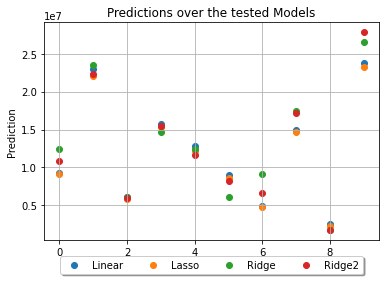

In [46]:
print(predictions)
modelDf = pd.DataFrame.from_dict(modelList,orient = 'index')
modelDf.head()
seq = range(10)
for i in range(4):
    p = plt.scatter(seq,predictions[i,])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4,labels = ls)
plt.grid()
plt.ylabel('Prediction')
plt.xlabel('Test Index')
plt.title('Predictions over the tested Models')
#sns.scatterplot(data = modelDf,y = ['Predictions'])

In [50]:
finalPred = predictions.mean(axis = 0)
print(finalPred)

[10382986.14919514 22731977.0635857   5961631.40044559 15287778.30205135
 12249477.26400693  7930889.59616423  6310661.63817154 16060417.55763943
  2025012.86354916 25380381.30202342]


In [39]:
def searchSold(district,roomC,roomF,numT,minLand,maxLand,minBuild,maxBuild):
    results = data.loc[(data['district'] == district) & 
             (data['num_room'] <= roomC) &
             (data['num_room'] >= roomF) & 
             (data['land_area'] <= maxLand) &
             (data['land_area'] >= minLand) &
             (data['building_area'] <= maxBuild) &
             (data['building_area'] >= minBuild) & 
             (data['num_toilet'] <= numT)]
    return results.sort_values(by=['total_ntd'])

In [40]:
searchSold('Beitou',4,2,1,30,50,80,100)

,district,total_ntd,land_area,main_building_material,building_area,num_room,num_hall,num_toilet,transaction_year,transaction_month,building_age
530,Beitou,4230000,32.75,Reinforced concrete construction,90.29,3,1,1,2019,12,1952.0
340,Beitou,8800000,33.75,Reinforced concrete construction,85.79,3,2,1,2019,9,1959.0
425,Beitou,10160000,33.33,Strengthen brickwork,82.41,3,2,1,2019,11,1957.0
576,Beitou,10500000,48.50,Reinforced concrete construction,90.67,3,1,1,2019,11,1957.0
304,Beitou,11000000,30.00,Reinforced concrete construction,95.70,3,2,1,2019,10,1956.0
279,Beitou,12550000,35.50,Reinforced concrete construction,94.10,3,2,1,2019,10,1957.0
1020,Beitou,13200000,35.00,Reinforced concrete construction,97.44,2,2,1,2019,11,1955.0
735,Beitou,13360000,32.25,Reinforced concrete construction,82.46,3,2,1,2019,11,1957.0
301,Beitou,14800000,35.75,Reinforced concrete construction,83.25,3,2,1,2019,10,1958.0
601,Beitou,17000000,50.00,Strengthen brickwork,97.81,3,2,1,2019,10,1959.0


In [41]:
searchSold('Daan District',4,2,2,20,40,100,120)

,district,total_ntd,land_area,main_building_material,building_area,num_room,num_hall,num_toilet,transaction_year,transaction_month,building_age
209,Daan District,16500000,39.69,Reinforced concrete construction,114.28,4,2,2,2019,12,1960.071429
633,Daan District,16680000,37.25,Reinforced concrete construction,105.52,3,2,2,2019,10,1960.071429
447,Daan District,18450000,29.20,Reinforced concrete construction,100.40,3,2,2,2019,11,1946.190476
553,Daan District,19480000,34.77,Reinforced concrete construction,117.90,3,2,2,2019,11,1948.000000
901,Daan District,20000000,30.88,Reinforced concrete construction,117.68,3,2,1,2019,12,1948.000000
130,Daan District,20660000,28.84,Reinforced concrete construction,105.09,4,2,1,2019,11,1947.000000
1009,Daan District,21000000,28.20,Reinforced concrete construction,103.58,2,2,1,2019,9,1946.190476
742,Daan District,21980000,22.66,Reinforced concrete construction,103.71,3,2,2,2019,11,1944.000000
251,Daan District,23200000,32.95,Reinforced concrete construction,116.56,3,2,2,2019,10,1949.000000
895,Daan District,23500000,21.91,Reinforced concrete construction,113.11,3,2,2,2019,12,1945.000000


In [42]:
searchSold('Xinyi District',2,2,1,0,200,0,200)
#data.loc[(data['district'] == 'Xinyi District')]

,district,total_ntd,land_area,main_building_material,building_area,num_room,num_hall,num_toilet,transaction_year,transaction_month,building_age
1224,Xinyi District,800000,2.81,Strengthen brickwork,4.42,2,1,1,2019,12,1963.000000
1244,Xinyi District,2200000,4.00,Strengthen brickwork,10.12,2,1,1,2019,12,1961.000000
1166,Xinyi District,7950000,12.12,Reinforced concrete construction,54.61,2,2,1,2019,11,1939.000000
1223,Xinyi District,8600000,24.75,Reinforced concrete construction,69.28,2,2,1,2019,12,1952.000000
1234,Xinyi District,8750000,22.50,Reinforced concrete construction,63.42,2,1,1,2019,12,1955.000000
1012,Xinyi District,9500000,13.40,Reinforced concrete construction,62.19,2,1,1,2019,10,1947.000000
1208,Xinyi District,11000000,28.00,Reinforced concrete construction,88.11,2,2,1,2019,10,1952.000000
1283,Xinyi District,12500000,30.00,Reinforced concrete construction,75.24,2,2,1,2019,12,1939.000000
1282,Xinyi District,12500000,30.00,Reinforced concrete construction,75.24,2,2,1,2019,12,1939.000000
1172,Xinyi District,12650000,23.90,Reinforced concrete construction,81.72,2,2,1,2019,12,1944.000000
